In [44]:
import pyedflib
import pyeeg
import numpy as np
from feature_extraction import read_sig
from tqdm.notebook import tqdm
import pandas as pd
from sklearn.model_selection import KFold
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from catboost import CatBoostClassifier, Pool
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
import warnings
warnings.filterwarnings("ignore", category=np.VisibleDeprecationWarning) 
%matplotlib notebook

In [50]:
dataset_path = "../EEG/physionet.org/files/chbmit/1.0.0/"
data = pd.read_csv("dataset_window_31metrics.csv")

In [51]:
data = data.drop('Unnamed: 0', axis=1)
data = data.set_index('name')

In [52]:
data = data.fillna(0)

In [53]:
data['target'].value_counts()

0    3275
1     180
Name: target, dtype: int64

In [54]:
data

,f0,f1,f2,f3,f4,f5,f6,f7,f8,f9,...,f673,f674,f675,f676,f677,f678,f679,f680,f681,target
name,,,,,,,,,,,,,,,,,,,,,
chb01/chb01_01.edf_585485,0.689225,0.463703,2.171914,2.171914,0.557195,0.651404,89.849793,-602.295482,-33.015873,-4.102564,...,-4.102564,1.367521,4.884005,8.400488,13.089133,24.420024,33.015873,50.207570,82.637363,0
chb01/chb01_01.edf_610308,0.546263,0.451220,2.227070,2.227070,0.557423,0.337556,82.997913,-517.899878,-24.420024,-2.539683,...,-1.758242,3.321123,6.056166,8.791209,11.526252,19.731380,26.764347,38.095238,63.101343,0
chb01/chb01_01.edf_111171,0.868437,0.348337,1.810393,1.810393,0.562407,-0.070716,75.352770,-395.604396,-25.201465,-2.930403,...,-2.539683,1.367521,3.711844,6.056166,8.791209,15.433455,20.512821,27.936508,41.221001,0
chb01/chb01_01.edf_760108,0.961447,0.400843,1.915868,1.915868,0.560057,0.283832,79.364834,-418.266178,-22.857143,-1.367521,...,-1.367521,2.539683,4.493284,6.837607,9.572650,15.824176,20.122100,26.373626,37.313797,0
chb01/chb01_01.edf_364295,0.745113,0.444978,2.198900,2.198900,0.558058,0.253205,32.259341,-159.218559,-16.214896,0.195360,...,-1.367521,1.367521,2.930403,4.493284,6.446886,10.354090,13.089133,16.996337,21.684982,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
chb24/chb24_22.edf_139980,0.911854,0.409704,1.947320,1.947320,0.560007,0.232397,55.219398,-155.311355,-30.280830,-2.930403,...,-4.493284,2.539683,6.837607,10.744811,15.433455,25.982906,32.625153,41.611722,56.849817,0
chb24/chb24_22.edf_218810,0.757835,0.776935,2.236088,2.236088,0.553947,1.258801,72.901898,-1018.803419,-32.722833,0.195360,...,0.195360,6.056166,11.916972,19.340659,27.936508,48.253968,59.975580,76.385836,98.656899,0
chb24/chb24_22.edf_193076,0.769573,0.352655,1.769606,1.769606,0.561236,-0.051943,63.836253,-258.070818,-27.936508,0.195360,...,-4.493284,1.758242,5.274725,9.181929,13.089133,23.247863,30.280830,38.876679,53.724054,0


In [55]:
X, y = data.drop('target', axis=1), data.target

In [56]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, shuffle=True, random_state=10, stratify=y)

In [57]:
from sklearn.model_selection import KFold
n_fold = 10
cv = KFold(n_splits=n_fold, shuffle=True, random_state=10)
rec_, f1_ = [], []
clfs = []
params = {
            'iterations':1000,
            'learning_rate':0.1,
            'depth':6,
            'eval_metric':'F1'
}

for fold, (train_index, val_index) in enumerate(cv.split(X)):
    X_train = X.iloc[train_index,:]
    X_val = X.iloc[val_index,:]

    y_train = y.iloc[train_index]
    y_val = y.iloc[val_index]

    clf = CatBoostClassifier(**params)

    train_dataset = Pool(data=X_train,
                     label=y_train,
                     )

    eval_dataset = Pool(data=X_val,
                    label=y_val,
                    )

    clf.fit(train_dataset,
              use_best_model=True,
              verbose = 0,
              eval_set=eval_dataset)

    y_pred = clf.predict(Pool(data=X_test))

    rec_.append(sklearn.metrics.recall_score(y_test, y_pred))
    f1_.append(sklearn.metrics.f1_score(y_test, y_pred))
    clfs.append(clf)

    print(f"fold: {fold}, f1: {sklearn.metrics.f1_score(y_test, y_pred)}")
    print(f"fold: {fold}, recall: {sklearn.metrics.recall_score(y_test, y_pred)}")

print('CV mean recall:  {0:.4f}, std: {1:.4f}.'.format(np.mean(rec_), np.std(rec_)))
print('CV mean f1: {0:.4f}, std: {1:.4f}.'.format(np.mean(f1_), np.std(f1_)))

fold: 0, f1: 0.9772727272727273
fold: 0, recall: 0.9555555555555556
fold: 1, f1: 0.9887640449438202
fold: 1, recall: 0.9777777777777777
fold: 2, f1: 0.9655172413793104
fold: 2, recall: 0.9333333333333333
fold: 3, f1: 1.0
fold: 3, recall: 1.0
fold: 4, f1: 0.9662921348314608
fold: 4, recall: 0.9555555555555556
fold: 5, f1: 0.9534883720930233
fold: 5, recall: 0.9111111111111111
fold: 6, f1: 0.9777777777777777
fold: 6, recall: 0.9777777777777777
fold: 7, f1: 0.9655172413793104
fold: 7, recall: 0.9333333333333333
fold: 8, f1: 0.9555555555555556
fold: 8, recall: 0.9555555555555556
fold: 9, f1: 1.0
fold: 9, recall: 1.0
CV mean recall:  0.9600, std: 0.0278.
CV mean f1: 0.9750, std: 0.0160.


In [58]:
# Посмотрим как 
for n in range(10):
    pred = clfs[n].predict(Pool(data=X_test))
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y_test, pred).ravel()
    print(f"Catboost fold: {n} - tn: {tn}, fp: {fp}, fn: {fn}, tp: {tp}, recall = {sklearn.metrics.f1_score(y_test, pred)}")

Catboost fold: 0 - tn: 819, fp: 0, fn: 2, tp: 43, recall = 0.9772727272727273
Catboost fold: 1 - tn: 819, fp: 0, fn: 1, tp: 44, recall = 0.9887640449438202
Catboost fold: 2 - tn: 819, fp: 0, fn: 3, tp: 42, recall = 0.9655172413793104
Catboost fold: 3 - tn: 819, fp: 0, fn: 0, tp: 45, recall = 1.0
Catboost fold: 4 - tn: 818, fp: 1, fn: 2, tp: 43, recall = 0.9662921348314608
Catboost fold: 5 - tn: 819, fp: 0, fn: 4, tp: 41, recall = 0.9534883720930233
Catboost fold: 6 - tn: 818, fp: 1, fn: 1, tp: 44, recall = 0.9777777777777777
Catboost fold: 7 - tn: 819, fp: 0, fn: 3, tp: 42, recall = 0.9655172413793104
Catboost fold: 8 - tn: 817, fp: 2, fn: 2, tp: 43, recall = 0.9555555555555556
Catboost fold: 9 - tn: 819, fp: 0, fn: 0, tp: 45, recall = 1.0


In [59]:
for n in range(10):
    pred = clfs[n].predict(Pool(data=X))
    tn, fp, fn, tp = sklearn.metrics.confusion_matrix(y, pred).ravel()
    print(f"Catboost fold: {n} - tn: {tn}, fp: {fp}, fn: {fn}, tp: {tp}, recall = {sklearn.metrics.f1_score(y, pred)}")

Catboost fold: 0 - tn: 3275, fp: 0, fn: 6, tp: 174, recall = 0.983050847457627
Catboost fold: 1 - tn: 3275, fp: 0, fn: 5, tp: 175, recall = 0.9859154929577464
Catboost fold: 2 - tn: 3274, fp: 1, fn: 12, tp: 168, recall = 0.9627507163323782
Catboost fold: 3 - tn: 3275, fp: 0, fn: 4, tp: 176, recall = 0.9887640449438202
Catboost fold: 4 - tn: 3273, fp: 2, fn: 10, tp: 170, recall = 0.9659090909090908
Catboost fold: 5 - tn: 3275, fp: 0, fn: 13, tp: 167, recall = 0.962536023054755
Catboost fold: 6 - tn: 3274, fp: 1, fn: 5, tp: 175, recall = 0.9831460674157303
Catboost fold: 7 - tn: 3275, fp: 0, fn: 16, tp: 164, recall = 0.9534883720930233
Catboost fold: 8 - tn: 3273, fp: 2, fn: 5, tp: 175, recall = 0.9803921568627451
Catboost fold: 9 - tn: 3275, fp: 0, fn: 9, tp: 171, recall = 0.9743589743589743


In [66]:
best_model = clfs[3]
pred = best_model.predict(Pool(data=X))

## Посмотрим на каких окнах алгоритм не находит положительный класс (fn)

In [67]:
names = X[pred != y].index
print(names)

Index(['chb06/chb06_10.edf_2773248', 'chb20/chb20_14.edf_504576',
       'chb20/chb20_15.edf_432384', 'chb22/chb22_38.edf_323328'],
      dtype='object', name='name')


In [68]:
chanels = ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8']
start_window = int(names[0].rsplit('_', 1)[1])
sample_data = np.array(list(read_sig(f"{dataset_path}/{names[0].rsplit('_', 1)[0]}", chanels).values()))
indices = np.arange(start_window, start_window + 30*256)
sample_data = sample_data[:, indices]

<IPython.core.display.Javascript object>


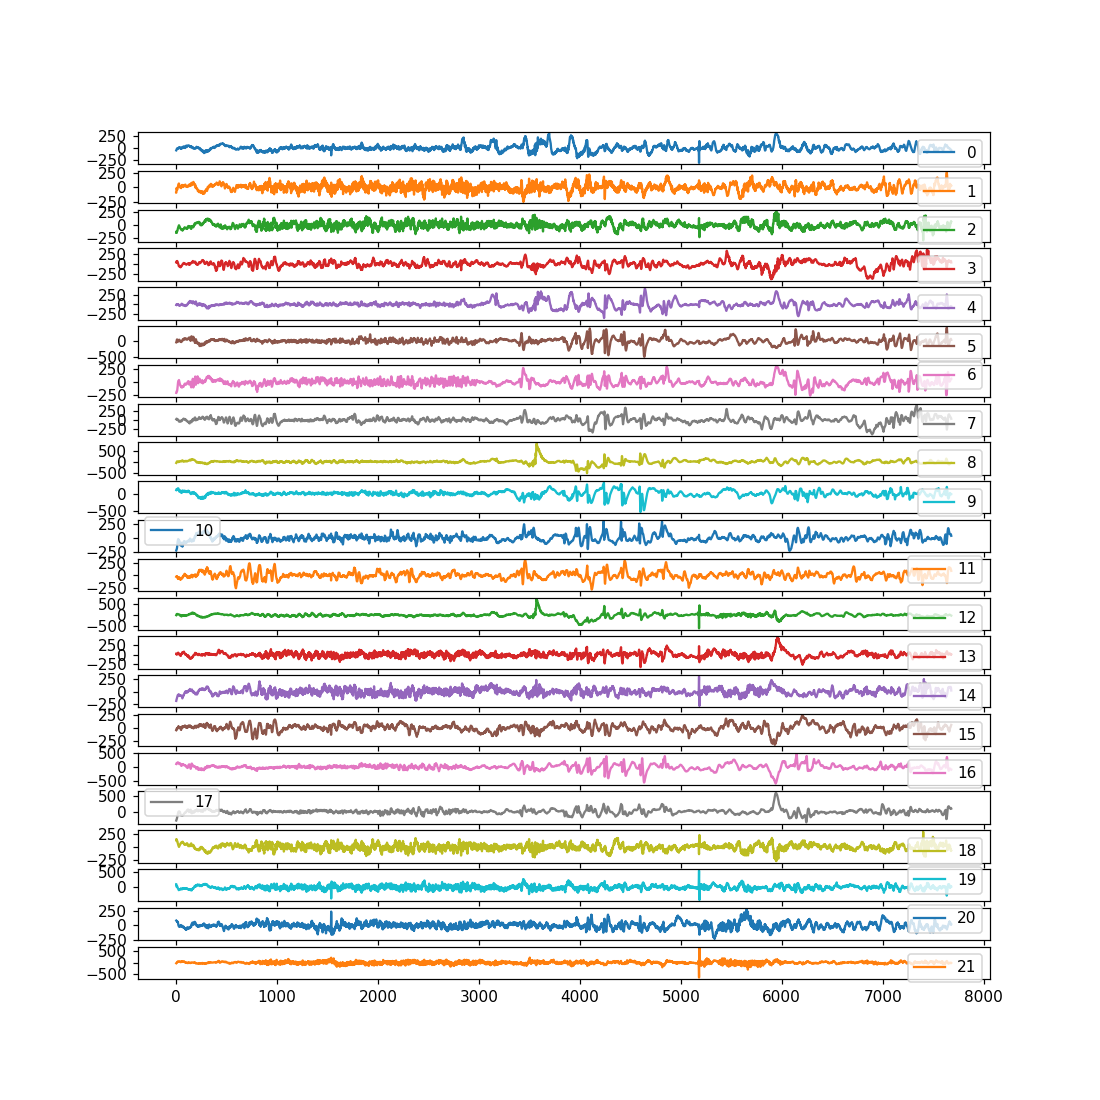

array([<matplotlib.axes._subplots.AxesSubplot object at 0x7f2aae02aad0>,
      dtype=object)

In [69]:
import matplotlib.pyplot as plt
pd.DataFrame(sample_data).T.plot(figsize=(10,10), subplots=True)
